A lot of the code was referenced from the segment-anything/notebooks

In [ ]:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-_hix3kmp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-_hix3kmp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=20a4c6138195e10f43c0698bd1d800ebcce6e3de33443f87db0024795cefd69c
  Stored in directory: /tmp/pip-ephem-wheel-cache-_wu9eqwc/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-10-10 01:59:52--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
# change this to picture you want, you might need to upload them first

image_url = 'images/profile.jpg'
# image_url = 'images/truck.jpg'

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([1])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

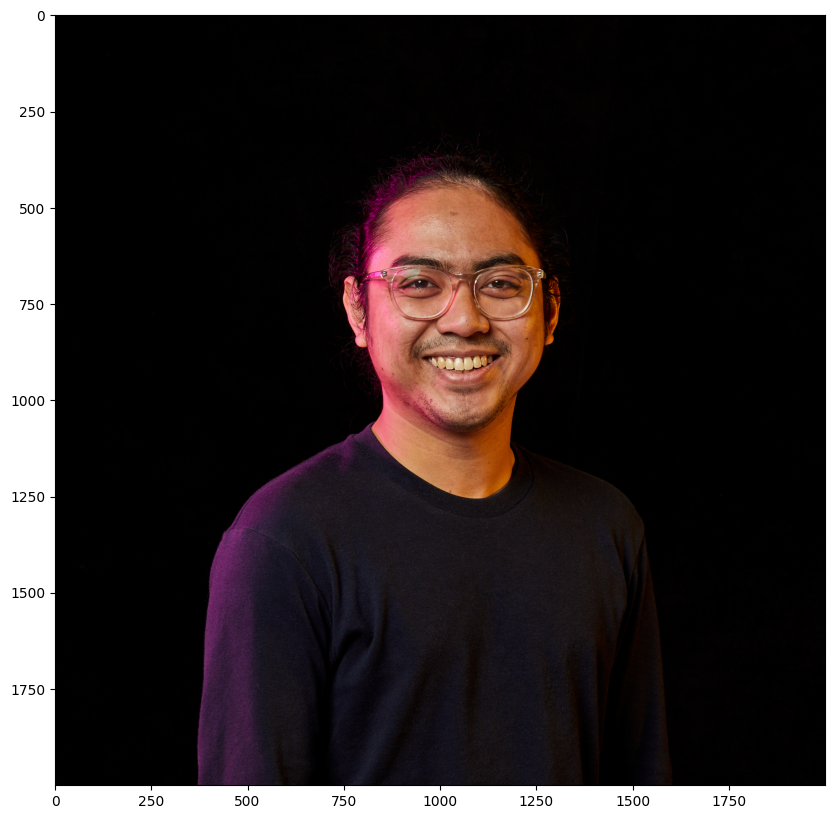

In [ ]:
image = cv2.imread(image_url)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# make sure your machine has a cuda supported GPU. NOTE: you can always run this in google colab to get a GPU runtime
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam) # initialise the predictor

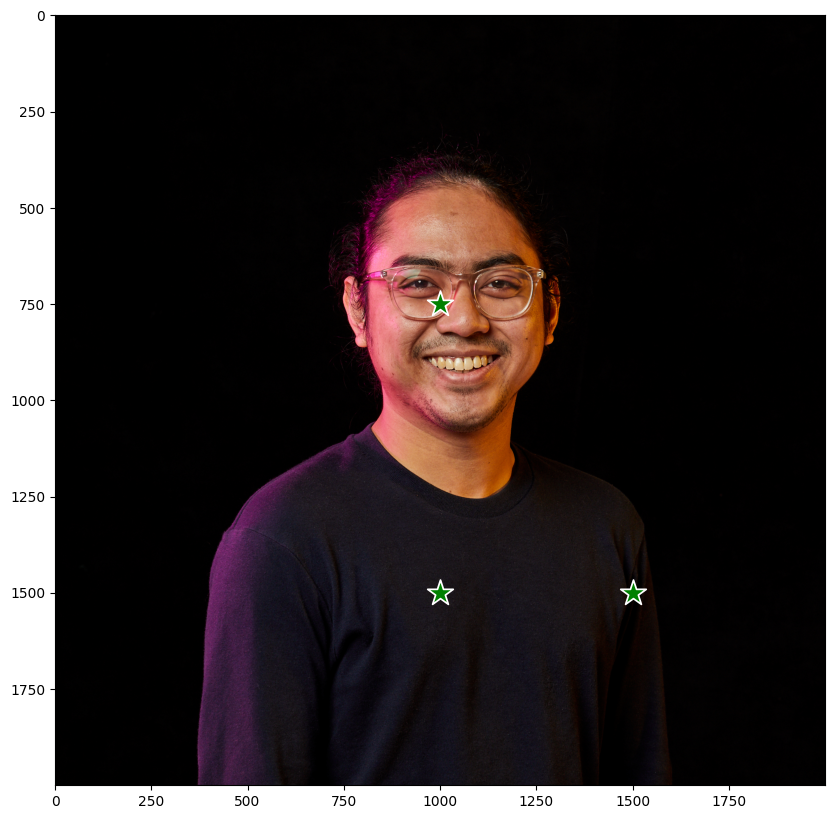

In [ ]:
predictor.set_image(image)

# point to some coordinates and label it
input_point = np.array([[1000, 1500], [1500, 1500], [1000, 750]])
# input_point = np.array([[1000, 600], [600, 600]]) # for the truck image

# give some context for the  model to predict
input_label = np.array([1, 1, 1])
# input_label = np.array([1, 1]) # for the truck image

# show where we point at
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

masks.shape  # (number_of_masks) x H x W

(3, 2000, 2000)

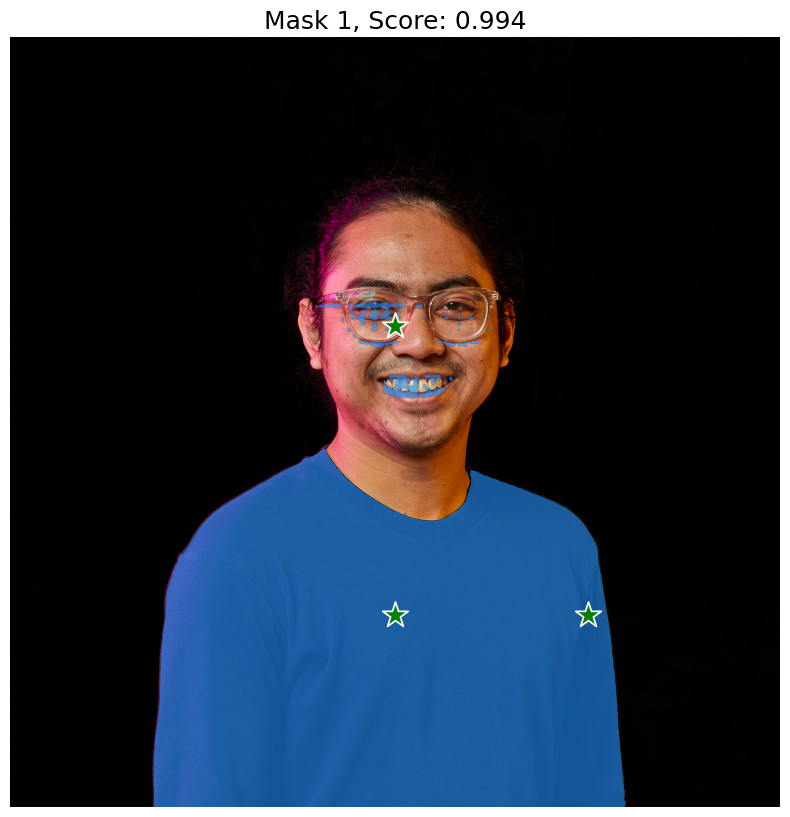

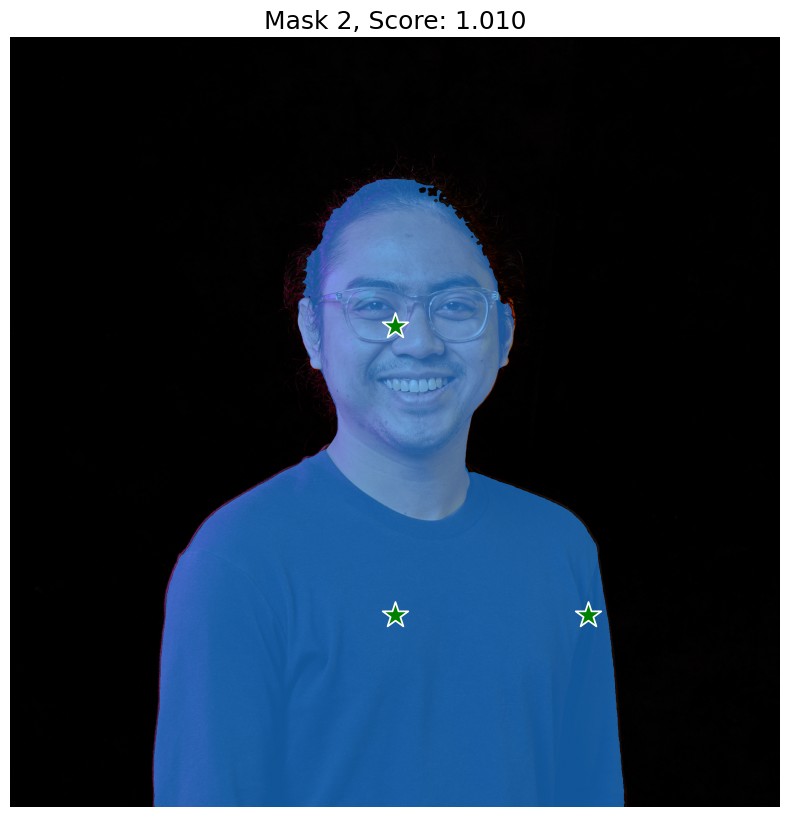

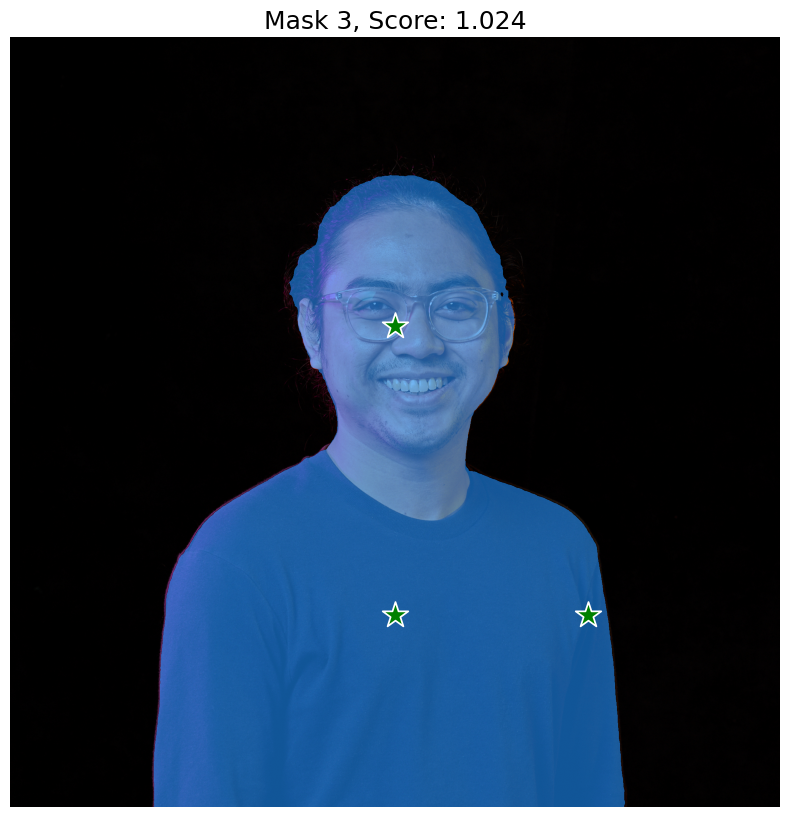

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [ ]:
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
masks.shape

(1, 2000, 2000)

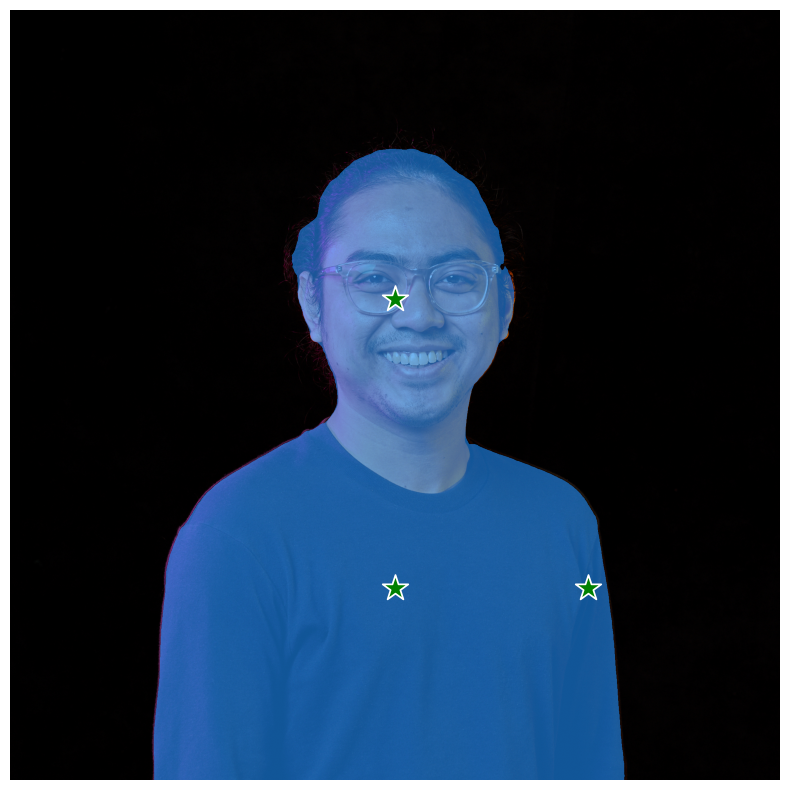

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [ ]:
inversed_mask = np.invert(masks[0])
inversed_mask.shape

(2000, 2000)

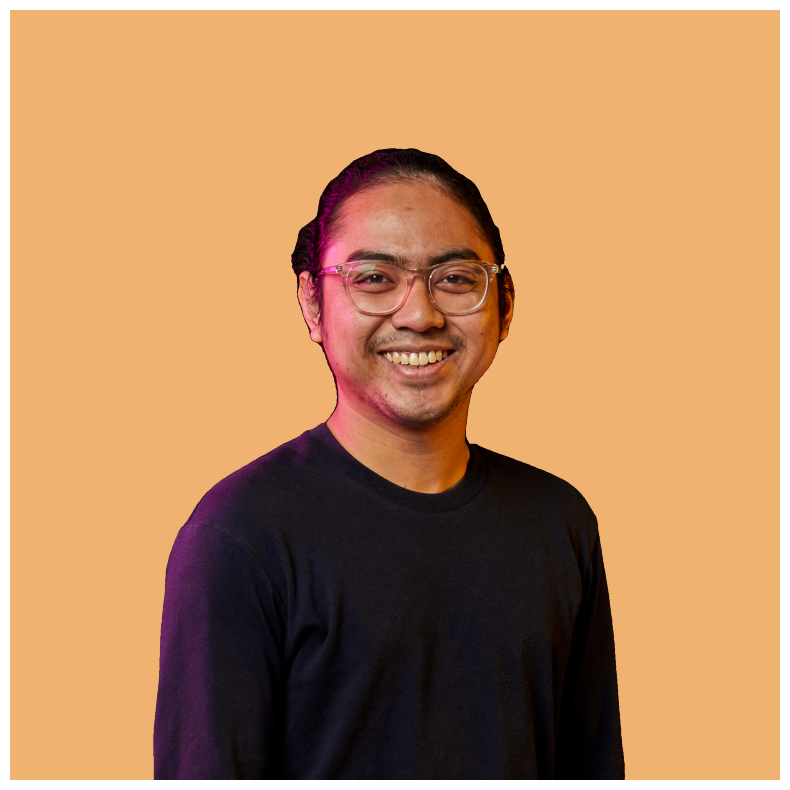

In [ ]:
plt.figure(figsize=(10,10), frameon=False)

plt.imshow(image)
show_mask(np.array([inversed_mask]), plt.gca(), random_color=True)
plt.axis('off')

# save it to disk
plt.savefig('./images/updated_profile.png')


plt.show()